# Imports and Functions 

## Imports and Constants

In [11]:
# Core libraries
import os
import sys
import glob
import csv
import time
import math
import argparse
import numpy as np
import scipy
import scipy.signal
import scipy.fftpack as fft
from scipy.special import eval_legendre, zeta
from scipy.signal.windows import tukey
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
import mpmath

# Astropy for FITS file handling
import astropy.io.fits as pyfits

# Matplotlib for plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.colors import LogNorm, hsv_to_rgb
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import Slider, EllipseSelector, RectangleSelector
from matplotlib.transforms import IdentityTransform
from matplotlib.figure import Figure
import matplotlib.mathtext as mathtext

# Image handling
from PIL import Image
import imageio
import requests

# Custom fit functions
from fitfunctions import (gaussmod, tfmod, bimodalmod, tfaxialmod, 
                          gaussmod_OAH, tfmod_OAH, bimodalmod_OAH)
# Custom OAH utilities
from OAH_refocus import *
from OAH_functions import *
from OAHDEV_functions import *

# Constants:
kB = 1.38064852E-23
m = 3.81923979E-26
hb = 1.0545718E-34
asc = 2.802642E-9
mu0 = 1E-50
e0 = 8.854187E-12
pix_size = 6.5E-6 / 2.63
lamb0 = 589.1E-9  # Wavelength
k0 = 2 * np.pi / lamb0  # k-vector

# Ensure clean matplotlib style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.style.use('fivethirtyeight')  
plt.style.use('default')  

# Wider Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [12]:
rng=np.random.default_rng() 
size=(2046, 2046) 
border=0

## Functions 

### Interference Generator

In [9]:
def makeInterference(size=size, angle1=200, angle2=240, condensate=0, wx=0.002, wy=0.1, 
                     curvature_probe=0.001, curvature1=0.001, curvature2=0.001, 
                     windowalpha=0.01, windowtype="tukey", 
                     ref_crosstalk=False):
    """ 
    Create an interference pattern of a probe and two reference beams with curved wavefronts.
    angle1: Angle of the first reference beam, in degrees?
    angle2: Angle of the second reference beam.
    condensate: 0 or 1 - Whether to include a condensate-like phase object.
    wx: Gaussian width in x.
    wy: Gaussian width in y.
    curvature_probe: Curvature parameter for the probe beam.
    curvature1: Curvature parameter for the first reference beam.
    curvature2: Curvature parameter for the second reference beam.
    """
    
    # Create grid for image
    x = np.linspace(-1, 1, size[0] + 2 * border)
    y = np.linspace(-1, 1, size[1] + 2 * border)
    Xgrid, Ygrid = np.meshgrid(x, y)
    
    # Create a condensate-like phase object
    gaussian_matrix = condensate * np.exp(-((Xgrid / wx)**2 + (Ygrid / wy)**2))
    True_phase = np.exp(3.0j * gaussian_matrix)
    
    # Define wave vectors based on the input angles
    k0 = angle1 * 2 * np.pi            # First reference beam wave number
    k1 = k0 * np.array([1.0, 1.0])     # First beam direction vector
    k02 = angle2 * 2 * np.pi           # Second reference beam wave number
    k2 = k02 * np.array([-1.0, 1.0])   # Second beam direction vector

    # Create the probe beam with curvature
    probe_beam = np.exp(1.0j * curvature_probe * (Xgrid**2 + Ygrid**2))
    
    # Create reference fields with curvature terms
    # Curvature terms: exp(j * curvature * (X^2 + Y^2)) 
    ref1 = np.exp(1.0j * np.tensordot(k1, [Xgrid, Ygrid], axes=[[0], [0]])) * np.exp(1.0j * curvature1 * (Xgrid**2 + Ygrid**2))
    ref2 = np.exp(1.0j * np.tensordot(k2, [Xgrid, Ygrid], axes=[[0], [0]])) * np.exp(1.0j * curvature2 * (Xgrid**2 + Ygrid**2))

#     # Generate interference patterns with the probe beam   
    if ref_crosstalk:
        InterferencePatternTotal = np.real((True_phase * probe_beam  + ref1 + ref2) * (True_phase * probe_beam  + ref1 + ref2).conj())
    
    else:
        InterferencePattern1 = np.real(True_phase * probe_beam * ref1) + 0.5
        InterferencePattern2 = np.real(True_phase * probe_beam * ref2) + 0.5
        InterferencePatternTotal = InterferencePattern1 + InterferencePattern2

    # Apply a window function for smoother edges in Fourier space
    window = 1
    if windowtype == "tukey":
        window = tukey(size[1], alpha=windowalpha, sym=True)[:, np.newaxis] * tukey(size[0], alpha=windowalpha, sym=True)[np.newaxis, :]
    
    elif windowtype == "oval":
        window = oval_window(size, alpha=windowalpha, aspect_ratio=1.5)

    elif windowtype == "triangle":
        window = triangular_window(size)

    elif windowtype == "circle":
        window = circular_window(size, radius=0.5)

    elif windowtype == "house":
        window = house_window(size, width_ratio=windowalpha, roof_height_ratio=0.3)

    Fourier_space = np.fft.fftshift(np.fft.fft2(InterferencePatternTotal * window))

    return InterferencePatternTotal * window, Fourier_space



In [13]:
def oval_window(size, alpha=0.5, aspect_ratio=1.5):
    """
    Creates an oval-shaped Tukey window.
    size: int, Size of the window (NxN).
    alpha: float, Shape parameter for the Tukey window (between 0 and 1).
    aspect_ratio: float, Ratio of width to height for the oval shape.
    """
    x = np.linspace(-1, 1, size[0])
    y = np.linspace(-1, 1, size[1])
    X, Y = np.meshgrid(x, y)
    R = np.sqrt((X**2) + (Y**2 / aspect_ratio**2))
    window = np.clip(1 - R, 0, 1) * tukey(size[0], alpha)[:, np.newaxis] * tukey(size[1], alpha)[np.newaxis, :]
    return window

def triangular_window(size):
    """
    Creates a triangular window.
    size: int, Size of the window (NxN).
    """
    x = np.linspace(-1, 1, size[0])
    y = np.linspace(-1, 1, size[1])
    X, Y = np.meshgrid(x, y)
    R = np.abs(X) + np.abs(Y)
    window = np.clip(1 - R, 0, 1)
    return window

def circular_window(size, radius=0.5):
    """
    Creates a circular window.
    size: int, Size of the window (NxN).
    radius: float, Radius of the circle (between 0 and 1).
    """
    x = np.linspace(-1, 1, size[0])
    y = np.linspace(-1, 1, size[1])
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    window = np.clip(1 - (R / radius), 0, 1)
    return window


def house_window(size, width_ratio=0.9, roof_height_ratio=0.3, roof_offset=0.6):
    """
    Creates a house-shaped window (a trapezoid with a triangular roof shifted upwards).
    size: int, Size of the window (NxN).
    width_ratio: float, Width of the base relative to the image width.
    roof_height_ratio: float, Height of the roof relative to the image height.
    roof_offset: float, Vertical shift of the roof relative to the center of the base.
    """
    x = np.linspace(-1, 1, size[0])
    y = np.linspace(-1, 1, size[1])
    X, Y = np.meshgrid(x, y)

    # Define the base (trapezoid) of the house
    base_window = np.clip(1 - np.abs(Y) / (1 - roof_height_ratio), 0, 1) * (np.abs(X) <= width_ratio)

    # Shift the triangular roof upward by `roof_offset`
    roof_window = np.clip(1 - (np.abs(X) / (2*width_ratio) + (-Y - roof_offset) / roof_height_ratio), 0, 1) * (Y <= -roof_offset + roof_height_ratio)

    # Combine base and roof to form the "house" shape
    window = np.maximum(base_window, roof_window)
    return window



### Fitting

In [14]:
# Initial values
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (50, 850),
    "tfa": 1,
    "tfw": (20, 50),
    "ga": 1,
    "gw": (200, 200),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

def fitting(pic, mode, init_guess=initial_fit_vals, normalize=False, invert=False, OAH=False):
    
    # Initial values
    offset = init_guess["offset"]
    amp_ov = init_guess["amp_ov"]
    ang = init_guess["ang"]
    center = init_guess["center"]
    tfa = init_guess["tfa"]
    tfw = init_guess["tfw"]    
    ga = init_guess["ga"]
    gw = init_guess["gw"]    
    j_guess = init_guess["j_guess"]
    axamp = init_guess["axamp"]    
    x_shift = init_guess["x_shift"]
    squeeze_par = init_guess["squeeze_par"]
    
#     print(init_guess)
    
    
    # Normalize everything between 1 and 0
    if normalize:
#         pic = pic[10:-10, 10:-10]
        pic = pic + abs(pic.min()) + 0.00001
        avg_bg = pic.mean()
        pic = pic/avg_bg

    if invert:
        # Normalize such that the background is at 1, the peak is at zero.         
        pic= - pic + 0.5

        
    mask = pic == 0
    pic = np.ma.array(pic, mask=mask)
    # Generate empty arrays of the pic size which we will feed into the fitting procedure.
    # Create a 'fitvars' array of x and y coordinates
    x = np.arange(pic.shape[0])
    y = np.arange(pic.shape[1])
    xv, yv = np.meshgrid(x, y, indexing='ij')
    fitvars = np.array([xv, yv]).reshape(2, -1)

    xbin = 1
    zbin = 1

    # Constants
    pixelsize = 2.47148288973384e-06 
    kB = 1.38064852E-23
    m = 3.81923979E-26
    hb = 1.0545718E-34
    asc = 2.802642E-9
    mu0 = 1e-50
    e0 = 8.854187E-12
    fx = 115
    fz = 15
    wavelength = 589e-9
    detuning = 0
    prefactor = float((1 + 4 * detuning ** 2) * 2 * np.pi / (3 * (wavelength ** 2)) * 18. / 5.)

    xmin, xmax, zmin, zmax = 0, 0, 0, 0
    
    par_names = ['offset', 'ampl', 'ang', 'xmid', 'ymid', 'tfamp', 'tfxw', 'tfyw', 'gamp', 'gxw', 'gyw']
    bin_scaling = np.array([1., 1., 1., xbin, zbin, 1., xbin, zbin, 1., xbin, zbin])
    rng_offset = np.array([0., 0., 0., xmin, zmin, 0., 0., 0., 0., 0., 0.])
    init_guess = np.array([offset, amp_ov, ang, center[0], center[1], tfa, tfw[0], tfw[1], ga, gw[0], gw[1]])
    to_physical = np.array([1., 1., 1., pixelsize, pixelsize, prefactor, pixelsize, pixelsize, prefactor, pixelsize, pixelsize])
    corr_guess = (init_guess - rng_offset) / bin_scaling

    if OAH:
        if mode == "gauss":
            corr_guess = np.append(corr_guess[:5], corr_guess[-3:])
            bin_scaling = np.append(bin_scaling[:5], bin_scaling[-3:])
            rng_offset = np.append(rng_offset[:5], rng_offset[-3:])
            par_names = np.append(par_names[:5], par_names[-3:])
            to_physical = np.append(to_physical[:5], to_physical[-3:])
            odrmodel = odr.Model(gaussmod_OAH)  # Store information for the gaussian fitting model

        if mode == "doubletf":
            corr_guess = np.append(corr_guess[:8], [center2[0], center2[1], tfa2, tfw2[0], tfw2[1]])
            bin_scaling = np.append(bin_scaling[:8], bin_scaling[3:8])
            rng_offset = np.append(rng_offset[:8], rng_offset[3:8])
            par_names = np.append(par_names[:8], par_names[3:8])
            to_physical = np.append(to_physical[:8], to_physical[3:8])
            odrmodel = odr.Model(double_tf_OAH)  # Store information for the gaussian fitting model

            
        if mode == "tf":
            corr_guess = corr_guess[:8]
            bin_scaling = bin_scaling[:8]
            rng_offset = rng_offset[:8]
            par_names = par_names[:8]
            to_physical = to_physical[:8]
            odrmodel = odr.Model(tfmod_OAH)  # Store information for the tf fitting model

        if mode == "bimodal":
            odrmodel = odr.Model(bimodalmod_OAH)  # Store information for the bimodal fitting model
            
        
    else: 
        if mode == "gauss":
            corr_guess = np.append(corr_guess[:5], corr_guess[-3:])
            bin_scaling = np.append(bin_scaling[:5], bin_scaling[-3:])
            rng_offset = np.append(rng_offset[:5], rng_offset[-3:])
            par_names = np.append(par_names[:5], par_names[-3:])
            to_physical = np.append(to_physical[:5], to_physical[-3:])
            odrmodel = odr.Model(gaussmod)  # Store information for the gaussian fitting model

        if mode == "tf":
            corr_guess = corr_guess[:8]
            bin_scaling = bin_scaling[:8]
            rng_offset = rng_offset[:8]
            par_names = par_names[:8]
            to_physical = to_physical[:8]
            odrmodel = odr.Model(tfmod)  # Store information for the tf fitting model

        if mode == "bimodal":
            odrmodel = odr.Model(bimodalmod)  # Store information for the bimodal fitting model

        if mode == "timecrystal":
            corr_guess = corr_guess[:8]
            corr_guess = np.append(corr_guess, j_guess)
            corr_guess = np.append(corr_guess, axamp)
            corr_guess = np.append(corr_guess, x_shift)
            corr_guess = np.append(corr_guess, squeeze_par)
            bin_scaling = bin_scaling[:8]
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            rng_offset = rng_offset[:8]
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            par_names = par_names[:8]
            par_names = np.append(par_names, "j parameter")
            par_names = np.append(par_names, "axamp")
            par_names = np.append(par_names, "x_shift")
            par_names = np.append(par_names, "squeeze_par")
            to_physical = to_physical[:8]
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            odrmodel = odr.Model(tfaxialmod)
        
       
    print(corr_guess)
    # Run the ODR Fit procedure.
    odrdata = odr.Data(fitvars[:, ~pic.mask.flatten()], pic.flatten()[~pic.mask.flatten()])
    odrobj = odr.ODR(odrdata, odrmodel, beta0=corr_guess)
    odrobj.set_job(2)  # Ordinary least-sqaures fitting
    odrout = odrobj.run()
#     odrout.pprint()


    if OAH:
        # This sets the angle to be correct wrt x and y.
        if np.abs(odrout.beta[2] % np.pi) > np.pi / 4.:
            odrout.beta[2] = odrout.beta[2] - np.pi / 2.
            print("Performing xy swap due to angle.")
            if mode == "bimodal":
                tmp_tfx = odrout.beta[6]
                tmp_gx = odrout.beta[-2]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp_tfx
                odrout.beta[-2] = odrout.beta[-1]
                odrout.beta[-1] = tmp_gx
            else:
                tmp = odrout.beta[6]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp

        if mode == "gauss":
            fitresult = gaussmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = gaussmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
        
        if mode == "doubletf":
            fitresult = double_tf_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = double_tf_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "tf":
            fitresult = tfmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "bimodal":
            fitresult = bimodalmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresulttf = tfmod_OAH(odrout.beta[:8], fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = gaussmod_OAH(np.append(odrout.beta[:5], odrout.beta[-3:]), fitvars).reshape(pic.shape[0],pic.shape[1])
            fitguess = bimodalmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
        
    else:
        # This sets the angle to be correct wrt x and y.
        if np.abs(odrout.beta[2] % np.pi) > np.pi / 4.:
            odrout.beta[2] = odrout.beta[2] - np.pi / 2.
            print("Performing xy swap due to angle.")
            if mode == "bimodal":
                tmp_tfx = odrout.beta[6]
                tmp_gx = odrout.beta[-2]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp_tfx
                odrout.beta[-2] = odrout.beta[-1]
                odrout.beta[-1] = tmp_gx
            else:
                tmp = odrout.beta[6]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp

        if mode == "gauss":
            fitresult = gaussmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = gaussmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
            
        if mode == "tf":
            fitresult = tfmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "bimodal":
            fitresult = bimodalmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresulttf = tfmod(odrout.beta[:8], fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = gaussmod(np.append(odrout.beta[:5], odrout.beta[-3:]), fitvars).reshape(pic.shape[0],pic.shape[1])
            fitguess = bimodalmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])

        if mode == "timecrystal":
            fitresult = tfaxialmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfaxialmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
        
#     print("The shape of the pic file: \n{:}\n".format(pic.shape))
#     print("The guess parameters: \n{:}\n".format(corr_guess))
#     print("Odrout: \n{:}\n".format(odrout.beta))

    # As the entire output, except for the angle and the offset, has to be positive,
    # we take the absolute value of the entire list, then put the angle and offset back in.
    offset_temp = odrout.beta[0]
    ang_temp = odrout.beta[2]
    odrout.beta = np.abs(odrout.beta)
    odrout.beta[0] = offset_temp
    odrout.beta[2] = ang_temp % np.pi
    
    # Converts the fit results to absolute pixel values in the unbinned image.
    fit_results = odrout.beta * bin_scaling + rng_offset
    phys_results = fit_results * to_physical

    tof = 0
    ncount = - np.log(pic.flatten()).sum() * prefactor * pixelsize ** 2 * xbin * zbin
    ntherm = 0
    ntf = 0
    tx = 0
    tz = 0
    mux = 0
    muz = 0
    mun = 0

    if mode == "gauss":
        ntherm = 2 * np.pi * phys_results[5] * phys_results[6] * phys_results[7]
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "tf":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]  # 2/5 = 8/15 / (4/3)
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "timecrystal":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]  # 2/5 = 8/15 / (4/3)
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "bimodal":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]
        ntherm = 2 * np.pi * phys_results[8] * phys_results[9] * phys_results[10]
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[9]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[10]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)

    ntotal = ntherm + ntf

    fitted_vars = (ncount, ntherm, ntf, tx, tz, mux, muz, mun)
    
    return pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout



In [15]:
# Fit and Rotate
###### ------------ ROTATE ---------------- 
# Since the condensates are pretty thin in the ODT, let's rotate them as well, so a linecut will be nicer. 
# Additionally, we will also be able to compare the fits themself. Fitting with TF model. 

def rotateFunction(ang1, ang2, mode="tf"):
    """
        We do it together for both, so that we also make sure that they are of
        the same size. Which we need for fitting. 
    """
    tfw = (ang1.shape[0]//5, ang1.shape[1]//2)
    gw = (ang1.shape[0]//5, ang1.shape[1]//2)
    fit_1 = fitting(ang1, init_guess=initial_g_1, mode="tf", OAH=True)
    fit_2 = fitting(ang2, init_guess=initial_g_2, mode="tf", OAH=True)
    # fit: pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout
    clear_output()

    print(f"Angle 1 = {fit_1[6].beta[2]*(180/np.pi)}")
    print(f"Angle 2 = {fit_2[6].beta[2]*(180/np.pi)}")
    print(fit_1[6].beta)
    
    # Rotating the image and also the fitresult
#     ang1_rot = rotate(fit_1[0], (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
#     ang2_rot = rotate(fit_2[0], (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')
    ang1_rot = rotate(ang1, (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
    ang2_rot = rotate(ang2, (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')
    fitresult1_rot = rotate(fit_1[1], (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
    fitresult2_rot = rotate(fit_2[1], (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')

    # If 90 degrees off: 
    if ang1_rot.shape[0] > ang1_rot.shape[1]:
        ang1_rot = np.transpose(np.transpose(np.transpose(ang1_rot)))
        fitresult1_rot = np.transpose(np.transpose(np.transpose(fitresult1_rot)))

    if ang2_rot.shape[0] > ang2_rot.shape[1]:
        ang2_rot = np.transpose(np.transpose(np.transpose(ang2_rot)))
        fitresult2_rot = np.transpose(np.transpose(np.transpose(fitresult2_rot)))

    # Also, let's minus the offset on all of them:
    ang1_rot -= fit_1[6].beta[0]
    ang2_rot -= fit_2[6].beta[0]

    fitresult1_rot -= fit_1[6].beta[0]
    fitresult2_rot -= fit_2[6].beta[0]
    
    
    # make sure ang1_rot and ang2_rot are the same size:
    xedge = min(ang1_rot.shape[0], ang2_rot.shape[0])
    yedge = min(ang1_rot.shape[1], ang2_rot.shape[1])
    ang1_rot = ang1_rot[0:xedge, 0:yedge]
    ang2_rot = ang2_rot[0:xedge, 0:yedge]
    fitresult1_rot = fitresult1_rot[0:xedge, 0:yedge]
    fitresult2_rot = fitresult2_rot[0:xedge, 0:yedge]
    
    
#     # After subtracting the background, fit with the double tf. 
#     fit_1 = fitting(ang1_rot, mode="doubletf", OAH=True)
#     fit_2 = fitting(ang2_rot, mode="doubletf", OAH=True)
#     # fit: pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout
#     clear_output()
    
    return [ang1_rot, ang2_rot, fitresult1_rot, fitresult2_rot, fit_1, fit_2]


def getCoords(date, shot):
    """ 
    Call this to open an image, and get coordinates. Coordinates 
    are automaticall saved into a global 'cut' variable
    """
    input_folder = f'/storage/data/{date}/{str(shot).zfill(4)}/'
    
    # Check for refocused one and display the 0th one
    files = []
    for file in os.listdir(input_folder):
        if file.startswith("pics"):
            files.append(file)

    if len(files) == 0:
        atom = pyfits.open(input_folder + '0.fits')[0].data.astype(float)[0]  # .mean(axis=0)
        flat = pyfits.open(input_folder + '1.fits')[0].data.astype(float)[0]  # .mean(axis=0)
        dark = pyfits.open(input_folder + '2.fits')[0].data.astype(float).mean(axis=0)
        pic = (atom - dark) / (flat - dark)
        vmin = 0
        vmax = 1.3

    else:
        pics = pyfits.open(input_folder + files[0])[0].data.astype(float)[0]  # .mean(axis=0)
        pic = pics
        vmin = -3 #pic.min()
        vmax = 3 #pic.max()


    def select_callback(eclick, erelease):
        """
        Callback for line selection.
        *eclick* and *erelease* are the press and release events.
        """
        global x1, x2, y1, y2
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        title.set_text("Coordinates Recorded: \n X = {:} - {:}, Y = {:} - {:} \nPress Enter to save.".format(round(x1), round(x2), round(y1), round(y2)))
        fig.canvas.draw_idle()


    def toggle_selector(event):
        print('Key pressed.')
        if event.key == 't':
            for selector in selectors:
                name = type(selector).__name__
                if selector.active:
                    print(f'{name} deactivated.')
                    selector.set_active(False)
                else:
                    print(f'{name} activated.')
                    selector.set_active(True)
        elif event.key == 'enter':
            global cut, lc
            cut = [int(y1), int(y2), int(x1), int(x2)]
            lc = int((y2 - y1)//2)
            title.set_text(f"{cut=} SAVED in 'cut'")
            fig.canvas.draw_idle()
            plt.close()
            clear_output()


    fig, ax = plt.subplots()
    ax.imshow(pic, vmin=vmin, vmax=vmax, interpolation='none', origin="lower")
    N = 100000  # If N is large one can see improvement by using blitting.
    x = np.linspace(0, 10, N)

    selectors = []
    for selector_class in [RectangleSelector]:
        selectors.append(selector_class(
            ax, select_callback,
            useblit=True,
            button=[1, 3],  # disable middle button
            minspanx=5, minspany=5,
            spancoords='pixels',
            interactive=True))
        fig.canvas.mpl_connect('key_press_event', toggle_selector)

    title = ax.set_title("Make a selection and \n press Enter to save the coordinates.")
    fig.canvas.draw_idle()
    plt.show()
    

# ANALYSIS

## Phase

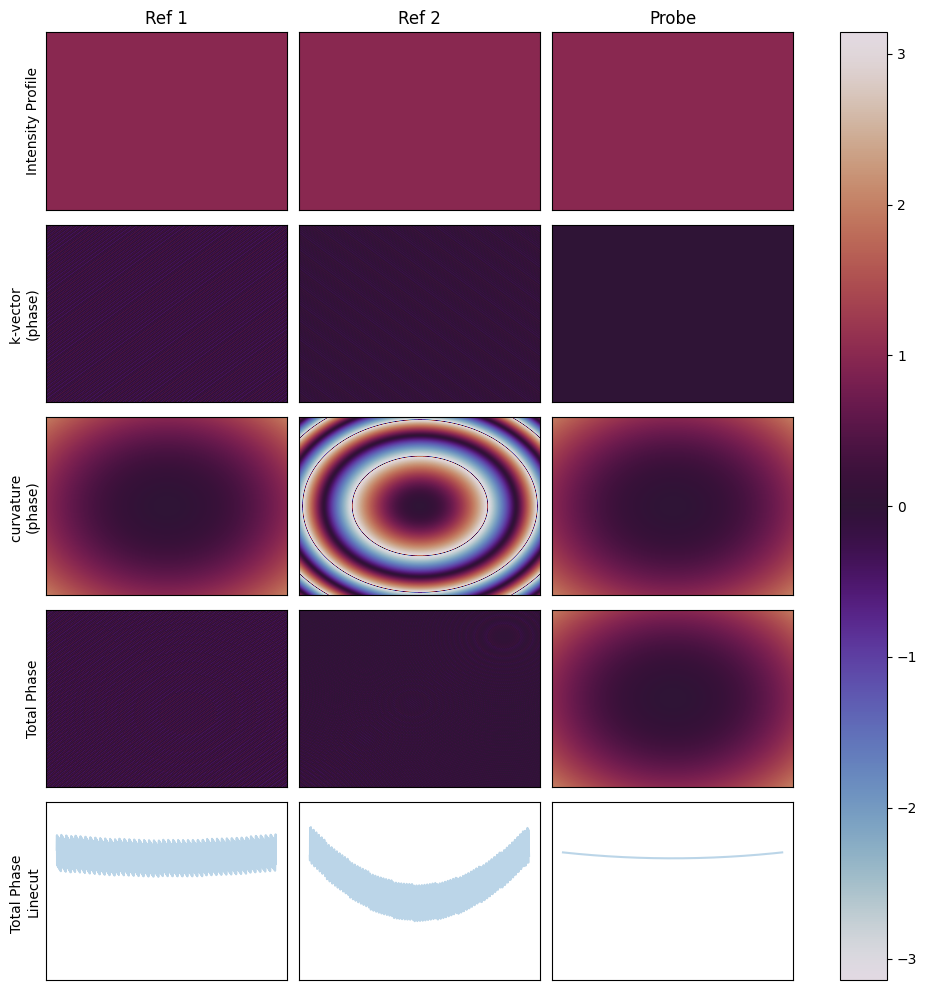

In [17]:
wx = 10
wy = 20

curvature_probe = 1
curvature1 = 1
curvature2 = 10
x = np.linspace(-1, 1, size[0] + 2 * border)
y = np.linspace(-1, 1, size[1] + 2 * border)
Xgrid, Ygrid = np.meshgrid(x, y)

# Create a condensate-like phase object
gaussian_matrix = 0 * np.exp(-((Xgrid / wx)**2 + (Ygrid / wy)**2))
True_phase = np.exp(3.0j * gaussian_matrix)

# Define wave vectors based on the input angles
k0 = 200 * 2 * np.pi            # First reference beam wave number
k1 = k0 * np.array([1.0, 1.0])     # First beam direction vector
k02 = 200 * k0                  # Second reference beam wave number
k2 = k02 * np.array([-1.0, 1.0])   # Second beam direction vector

# Create the probe beam with curvature
probe_beam = np.ones(size)
probe_beam_c = np.exp(1.0j * curvature_probe * (Xgrid**2 + Ygrid**2))

# Create reference fields with curvature terms
# Curvature terms: exp(j * curvature * (X^2 + Y^2)) 
ref1 = np.exp(1.0j * np.tensordot(k1, [Xgrid, Ygrid], axes=[[0], [0]])) 
ref1_c =  np.exp(1.0j * curvature1 * (Xgrid**2 + Ygrid**2))
ref2 = np.exp(1.0j * np.tensordot(k2, [Xgrid, Ygrid], axes=[[0], [0]]))
ref2_c = np.exp(1.0j * curvature2 * (Xgrid**2 + Ygrid**2))


fig, ax = plt.subplots(5, 3, figsize=(10, 10))
vmin = -np.pi 
vmax = np.pi

im = ax[0][0].imshow(np.real(ref1*np.conj(ref1)), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[0][1].imshow(np.real(ref2*np.conj(ref2)), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[0][2].imshow(np.real(probe_beam*np.conj(probe_beam)), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')

im = ax[1][0].imshow(np.angle(ref1), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[1][1].imshow(np.angle(ref2), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[1][2].imshow(np.angle(probe_beam), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')

im = ax[2][0].imshow(np.angle(ref1_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[2][1].imshow(np.angle(ref2_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[2][2].imshow(np.angle(probe_beam_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')

im = ax[3][0].imshow(np.angle(ref1 * ref1_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[3][1].imshow(np.angle(ref2 * ref2_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')
im = ax[3][2].imshow(np.angle(probe_beam * probe_beam_c), vmin=vmin, vmax=vmax, cmap='twilight', aspect='auto')


ax[4][0].plot(np.unwrap(np.angle(ref1_c)[256]) + np.angle(ref1)[256], alpha=0.3)
ax[4][1].plot(np.unwrap(np.angle(ref2_c)[256]) + np.angle(ref2)[256], alpha=0.3)
ax[4][2].plot(np.angle(probe_beam * probe_beam_c)[256], alpha=0.3)

ax[4][0].set_ylim([-20, 10])
ax[4][1].set_ylim([-20, 10])
ax[4][2].set_ylim([-20, 10])


for axs in ax:
    for a in axs:
        a.set_xticks([])
        a.set_yticks([])
    
ax[0][0].set_ylabel("Intensity Profile")
ax[1][0].set_ylabel("k-vector \n(phase)")
ax[2][0].set_ylabel("curvature \n(phase)")
ax[3][0].set_ylabel("Total Phase")
ax[4][0].set_ylabel("Total Phase \nLinecut")

ax[0][0].set_title("Ref 1")
ax[0][1].set_title("Ref 2")
ax[0][2].set_title("Probe")

plt.tight_layout()
plt.colorbar(im, ax=ax, aspect=20)

plt.show()

## Curvature

In [31]:
from matplotlib.patches import Ellipse

wx = 0.004
wy = 0.04

fig, ax = plt.subplots(2, 3, figsize=(15, 10))


for i in range(2): 
    interference, FS = makeInterference(size=(2046, 2046), angle1=200, angle2=300, condensate=i, wx=wx, wy=wy, curvature_probe=1, curvature1=1, curvature2=50, windowalpha=0.5)
    ax[0][i].imshow(interference)
    ax[1][i].imshow(np.fft.fftshift(np.abs(FS)),vmin=0,vmax=1000)
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    ax[0][i].set_xlim([923,1123])
    ax[0][i].set_ylim([923,1123])
    



interference, FS = makeInterference(size=(2046, 2046), angle1=200, angle2=300, condensate=i, wx=wy, wy=wx, curvature_probe=1, curvature1=1, curvature2=50, windowalpha=0.5)
ax[0][2].imshow(interference)
ax[1][2].imshow(np.fft.fftshift(np.abs(FS)),vmin=0,vmax=1000)
ax[0][2].set_xticks([])
ax[1][2].set_xticks([])
ax[0][2].set_yticks([])
ax[1][2].set_yticks([])
ax[0][2].set_xlim([923,1123])
ax[0][2].set_ylim([923,1123])


ellipse1 = Ellipse(xy=(2046//2, 2046//2), width=2046*wx, height=2046*wy, edgecolor='None', fc="k", alpha=0.1)
ellipse2 = Ellipse(xy=(2046//2, 2046//2), width=2046*wy, height=2046*wx, edgecolor='None', fc="k", alpha=0.1)

ax[0][1].add_patch(ellipse1)
ax[0][2].add_patch(ellipse2)

    
ax[0][0].set_title("No Condensate")
ax[0][1].set_title("Condensate")
ax[0][2].set_title("Flipped Aspect")
ax[0][0].set_ylabel("Interference Pattern")
ax[1][0].set_ylabel("Fourier Plane")

plt.suptitle("Introducing different curvature of the two beams. \nCurvature of Ref1 = Curvature of Probe = 1/40 Curvature of Ref 2")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(2, 6, figsize=(15, 7))
curvatures_2 = [1, 5, 10, 20, 50, 100] 

for i in range(6): 
    interference, FS = makeInterference(size=(2046, 2046), angle1=200, angle2=300, condensate=0, wx=0.002, wy=0.1, curvature_probe=0.1, curvature1=0.1, curvature2=curvatures_2[i], windowalpha=0.5)
    ax[0][i].imshow(interference[923:1123, 923:1123])
    ax[1][i].imshow(np.fft.fftshift(np.abs(FS)),vmin=0,vmax=1000)
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    ax[0][i].set_title(f"Curvature of second ref \n= {curvatures_2[i]} x Probe", fontsize=11)
    
ax[0][0].set_ylabel("Interference Pattern")
ax[1][0].set_ylabel("Fourier Plane")

#     plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Cutting Window

### Window size

In [33]:
fig, ax = plt.subplots(2, 6, figsize=(15, 7))
w_alphas = np.array([1, 5, 10, 20, 50, 100])*0.01

for i in range(6): 
    interference, FS = makeInterference(size=(2046, 2046), angle1=200, angle2=300, condensate=0, wx=0.002, wy=0.1, curvature_probe=0.1, curvature1=0.1, curvature2=20, windowalpha=w_alphas[i])
    ax[0][i].imshow(interference)#[923:1123, 923:1123])
    ax[1][i].imshow(np.fft.fftshift(np.abs(FS)),vmin=0,vmax=1000)
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    ax[0][i].set_title(f"tukey alpha \n= {w_alphas[i]}")
    
ax[0][0].set_ylabel("Interference Pattern")
ax[1][0].set_ylabel("Fourier Plane")
plt.suptitle("All Curvature of Ref 2 = 20 x Probe")

#     plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

### Window Shape

In [37]:
fig, ax = plt.subplots(2, 5, figsize=(15, 7), sharex=True, sharey=True)
curvatures_2 = [1, 2, 5, 10, 20, 50] 
tukeyalphas = [0.5]
wintypes = ["tukey", "oval", "triangle", "circle", "house"]

for i in range(5): 
    interference, FS = makeInterference(angle1=200, angle2=100, condensate=0, wx=0.002, wy=0.1, curvature_probe=0.1, curvature1=0.1, curvature2=60, windowalpha=0.4, windowtype=wintypes[i])
    ax[0][i].imshow(interference)#[923:1123, 923:1123])
    ax[1][i].imshow(np.fft.fftshift(np.abs(FS)),vmin=0,vmax=1000)
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    ax[0][i].set_title(f"Window type \n= {wintypes[i]}")
    
ax[0][0].set_ylabel("Interference Pattern")
ax[1][0].set_ylabel("Fourier Plane")

#     plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Simulating The Displacement

In [19]:
border_x = 50
border_z = 50
def HI_refocus_synthetic(atoms, flat, dz_focus, quad="quad1", cut=[xmin, xmax, zmin, zmax]):
    """
    Main function for generating the output arrays for the holgoraphic imaging, which also includes the refocusing.
    What we do, is we process image - first take a FTT, apply Tukey windows, shift, refocus, and back iFFT.
    ------
    :param date: Input date of the image to be analysed
    :param shot: Input shot of the image to be analysed
    :param num: Input sequence number of the image to be analysed
    :param dz_focus: The focus parameter that determines the focus of the image
    :param quad: Parameter to determine which quad we are cutting.
    :param plot: Boolean to specify whether to plot the image of the angle or not. Better not when used in a loop.
    :return: Returns an array of the angle of the ratio of the iFFT's of the atom and flat image.
    """
    # ----------------------------------------------- CORRECTIONS ---------------------------------------------------
    # Creates a squaroid dark edge
    atoms = f1.squaroid(atoms, width=0.51)
    flat = f1.squaroid(flat, width=0.51)

    # --------------------------------------------------- FFT --------------------------------------------------------
    # Take the FTT of the atoms
    fft_atoms = np.fft.fft2(atoms)
    fft_flat = np.fft.fft2(flat)

    # We create the Tukey windows cutouts for the data and the background. Additional cuts in x,z direction can be
    # passed, but this is optional; the default value is 0. Note that because you later cut everything in the
    # same size, this may affect the rest too.
    quad1, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, 10, 100, edge_x=10, edge_z=80)
    flatq1, f1peak = f1.box_cutter_pad_ellips(fft_flat, quad, indices=q1peak)

    # Cutting the quads in the same sizes.
    quad1cut, flatq1cut = f1.sizecomp(quad1, flatq1)

    # ------------------------------------------------ FFT SHIFT ----------------------------------------------------
    # Now we FFT shift the zero frequency to the center
    fft1 = np.fft.fftshift(quad1cut)
    flatfft1 = np.fft.fftshift(flatq1cut)

    # ------------------------------------------------ REFOCUSING ---------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied
    ly = 0  # .5E6#-3E6#.                                           # Adjusting the fft_ky array
    coma_y_arg = ly * fft_ky[:, None] * (3 * fft_k2 / k0 ** 2) / k0
    lin_y = np.exp(-1j * coma_y_arg)

    # Determine the focus factor and refocus
    focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))
    fft1 = fft1 * focus * lin_y
    flatfft1 = flatfft1 * focus * lin_y

    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)
    

    inv1 = inv1[border_x:-border_x, border_z:-border_z]

    # Get Phase
    ang1 = np.angle(inv1)
    ang1 = f1.unwrapper(ang1)

    # Normalize
    normfactor = ang1.mean()  # [300:900, 300:900].mean()
    ang1 = ang1 - normfactor
#     ang1 = normalize(ang1)[0] # Use the function above to normalize the image.
    
    return ang1



In [33]:
atoms, FS_a = makeInterference(size=(2046, 2046), angle1=350, angle2=250, condensate=1, wx=0.5, wy=0.002, curvature_probe=0.1, curvature1=10, curvature2=10, windowalpha=0.5)#, ref_crosstalk=False)
flat, FS_f  = makeInterference(size=(2046, 2046), angle1=350, angle2=250, condensate=0, wx=0.2, wy=0.02, curvature_probe=0.1, curvature1=10, curvature2=10, windowalpha=0.5)#, ref_crosstalk=False)

## add noise 
atoms = atoms * np.random.normal(np.mean(atoms), 0.3, atoms.shape)
flat = flat * np.random.normal(np.mean(flat), 0.3, flat.shape)

ang1 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1")
ang2 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2")

Using the new box cutter
------ r='quad1' ------
(array([701]), array([702]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad1' ------
Indices provided: 
(2046, 2046) (2046, 2046)
Using the new box cutter
------ r='quad2' ------
(array([502]), array([1544]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad2' ------
Indices provided: 
(2046, 2046) (2046, 2046)


<ipython-input-19-854327db9109>:54: RuntimeWarning: divide by zero encountered in divide
  inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)


Using the new box cutter
------ r='quad1' ------
(array([701]), array([702]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad1' ------
Indices provided: 
(2046, 2046) (2046, 2046)
Using the new box cutter
------ r='quad2' ------
(array([502]), array([1544]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad2' ------
Indices provided: 
(2046, 2046) (2046, 2046)


<ipython-input-19-854327db9109>:54: RuntimeWarning: divide by zero encountered in divide
  inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)
<ipython-input-36-64e232f2d06f>:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


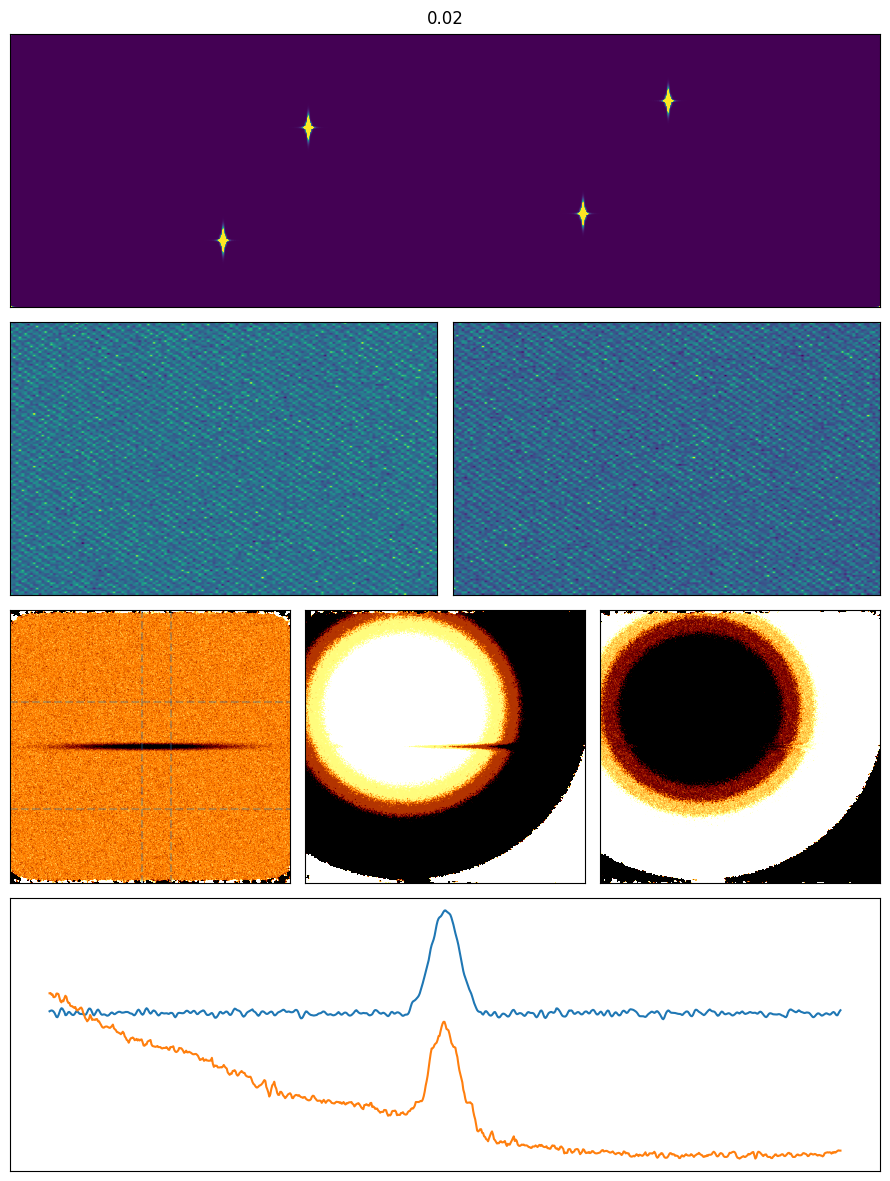

In [36]:
# for w_y in np.linspace(0.002, 0.5, 100):
for w_y in [0.02]:
    atoms, FS_a = makeInterference(size=(2046, 2046), angle1=350, angle2=250, condensate=1, wx=0.5, wy=w_y, curvature_probe=0.1, curvature1=10, curvature2=10, windowalpha=0.5)#, ref_crosstalk=False)
    flat, FS_f  = makeInterference(size=(2046, 2046), angle1=350, angle2=250, condensate=0, wx=0.2, wy=0.02, curvature_probe=0.1, curvature1=10, curvature2=50, windowalpha=0.5)#, ref_crosstalk=False)

    ## add noise 
    atoms = atoms * np.random.normal(np.mean(atoms), 0.3, atoms.shape)
    flat = flat * np.random.normal(np.mean(flat), 0.3, flat.shape)

    ang1 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1")
    ang2 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2")

    fig = plt.figure(layout="constrained", figsize=(9, 12))
    gs = GridSpec(4, 6, figure=fig)
    ax0 = fig.add_subplot(gs[0, :])
    axatoms = fig.add_subplot(gs[1, 0:3])
    axflat = fig.add_subplot(gs[1, 3:])
    ax1 = fig.add_subplot(gs[2, 0:2])
    ax2 = fig.add_subplot(gs[2, 2:4])
    axdiff = fig.add_subplot(gs[2, 4:6])
    ax3 = fig.add_subplot(gs[3, :])


    ax0.imshow(np.abs(fft.fftshift(FS_a)), aspect='auto', vmin=0, vmax=1000)
    axatoms.imshow(atoms[550:700, 550:700], aspect='auto')# vmin=-1.3, vmax=1.3 )
    axflat.imshow(flat[550:700, 550:700], aspect='auto')# vmin=-1.3, vmax=1.3 )

    ax1.imshow(ang1, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')
    ax2.imshow(ang2, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')
    axdiff.imshow(ang1-ang2, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')

    wdth_y = 100
    wdth_x = 400

    ax1.axvline(x=1023-border_x-wdth_y, alpha=0.3, ls='--')
    ax1.axvline(x=1023-border_x+wdth_y, alpha=0.3, ls='--')
    ax1.axhline(y=1003-border_z-wdth_x, alpha=0.3, ls='--')
    ax1.axhline(y=1003-border_z+wdth_x, alpha=0.3, ls='--')

    ax3.plot(ang1.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C0')
    ax3.plot(ang2.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C1')


    for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])


        
    plt.suptitle(f"{w_y}")
    plt.tight_layout()
    
#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/OAH_missmatch/simulations/w_z/{str(round(w_y*1000)).zfill(6)}.png")
    plt.show()




In [22]:
for noise_amount in [0.5]:
    for rc_b in [0]:
        for w_y in [0.2]:
            atoms, FS_a = makeInterference(size=(2046, 2046), angle1=300, angle2=350, condensate=1, wx=0.2, wy=w_y, curvature_probe=0.1, curvature1=10, curvature2=50, windowalpha=0.5, ref_crosstalk=rc_b)
            flat, FS_f  = makeInterference(size=(2046, 2046), angle1=300, angle2=350, condensate=0, wx=0.2, wy=0.02, curvature_probe=0.1, curvature1=10, curvature2=50, windowalpha=0.5, ref_crosstalk=rc_b)

            # add noise 
#             atoms = atoms * np.random.normal(np.mean(atoms), noise_amount, atoms.shape)
#             flat = flat * np.random.normal(np.mean(flat), noise_amount, flat.shape)

            # Minus for ref cross-talk
            ang1 = (1-2*rc_b)*HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1")
            ang2 = (1-2*rc_b)*HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2")

            
            ang1 = ang1 + generate_perlin_noise_2d_tf(ang1.shape, scale=100, seed=None).numpy()
            ang2 = ang2 + generate_perlin_noise_2d_tf(ang1.shape, scale=100, seed=None).numpy()
            
            fig = plt.figure(layout="constrained", figsize=(9, 12))
            gs = GridSpec(4, 6, figure=fig)
            ax0 = fig.add_subplot(gs[0, :])
            axatoms = fig.add_subplot(gs[1, 0:3])
            axflat = fig.add_subplot(gs[1, 3:])
            ax1 = fig.add_subplot(gs[2, 0:2])
            ax2 = fig.add_subplot(gs[2, 2:4])
            axdiff = fig.add_subplot(gs[2, 4:6])
            ax3 = fig.add_subplot(gs[3, :])

            

            ax0.imshow(np.log(np.abs((FS_a))),cmap='viridis')# aspect='auto', vmin=-10, vmax=10)#, vmin=0, vmax=1000)
            axatoms.imshow(atoms[550:700, 550:700], aspect='auto')# vmin=-1.3, vmax=1.3 )
            axflat.imshow(flat[550:700, 550:700], aspect='auto')# vmin=-1.3, vmax=1.3 )

            ax1.imshow(ang1, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')
            ax2.imshow(ang2, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')
            axdiff.imshow(ang1-ang2, vmin=-2, vmax=2, cmap="afmhot_r", origin="lower", aspect='auto')

            wdth_y = 100
            wdth_x = 400

            ax1.axvline(x=1023-border_x-wdth_y, alpha=0.3, ls='--')
            ax1.axvline(x=1023-border_x+wdth_y, alpha=0.3, ls='--')
            ax1.axhline(y=1003-border_z-wdth_x, alpha=0.3, ls='--')
            ax1.axhline(y=1003-border_z+wdth_x, alpha=0.3, ls='--')

            ax3.scatter(np.linspace(0, wdth_y, wdth_y), ang1.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C0')
            ax3.scatter(np.linspace(0, wdth_y, wdth_y), ang2.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C1')


            for ax in fig.axes:
                ax.set_xticks([])
                ax.set_yticks([])

            plt.suptitle(f"Reference Cross-talk: {rc_b}")
            plt.tight_layout()

        #     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/OAH_missmatch/simulations/w_z_ref_cross/{str(round(w_y*1000)).zfill(6)}.png")
            plt.show()




Using the new box cutter
------ r='quad1' ------
(array([600]), array([599]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad1' ------
Indices provided: 
(2046, 2046) (2046, 2046)
Using the new box cutter
------ r='quad2' ------
(array([700]), array([1345]))
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad2' ------
Indices provided: 
(2046, 2046) (2046, 2046)


<ipython-input-19-854327db9109>:54: RuntimeWarning: divide by zero encountered in divide
  inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)


NameError: name 'generate_perlin_noise_2d_tf' is not defined

#### Daniel's Code

<IPython.core.display.Javascript object>


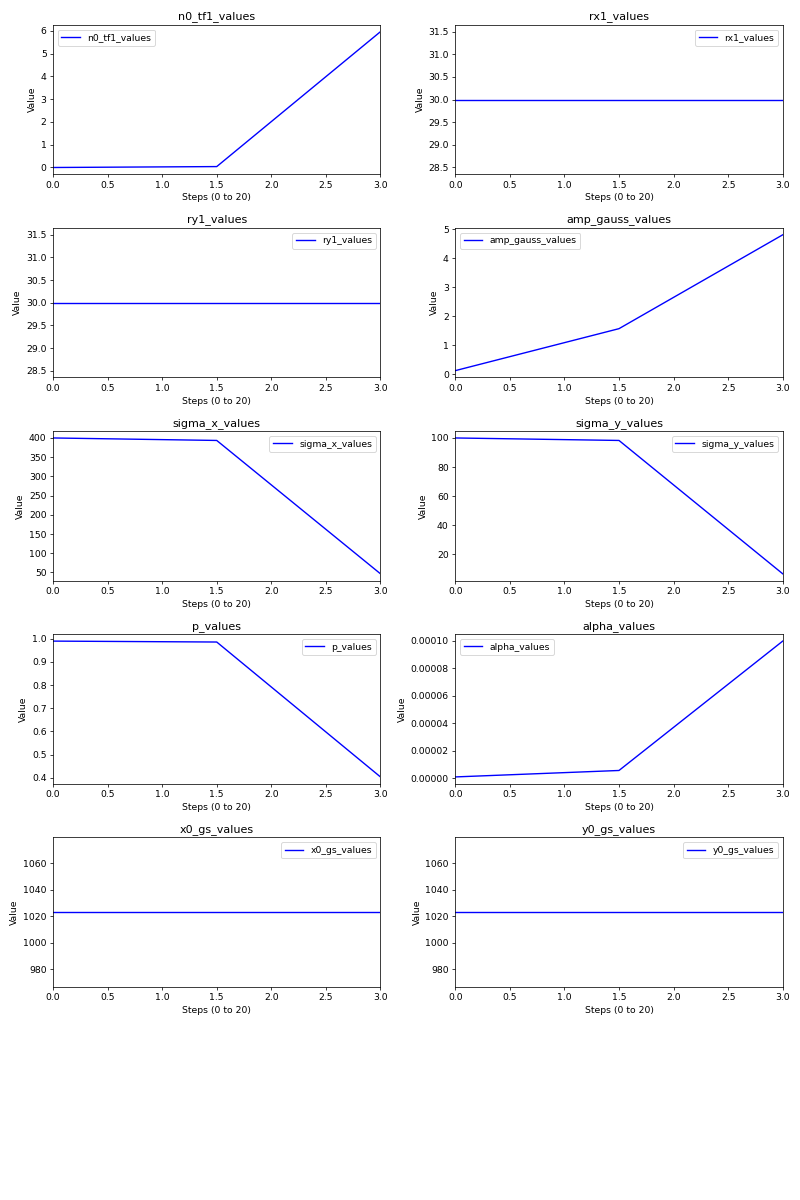

<IPython.core.display.Javascript object>


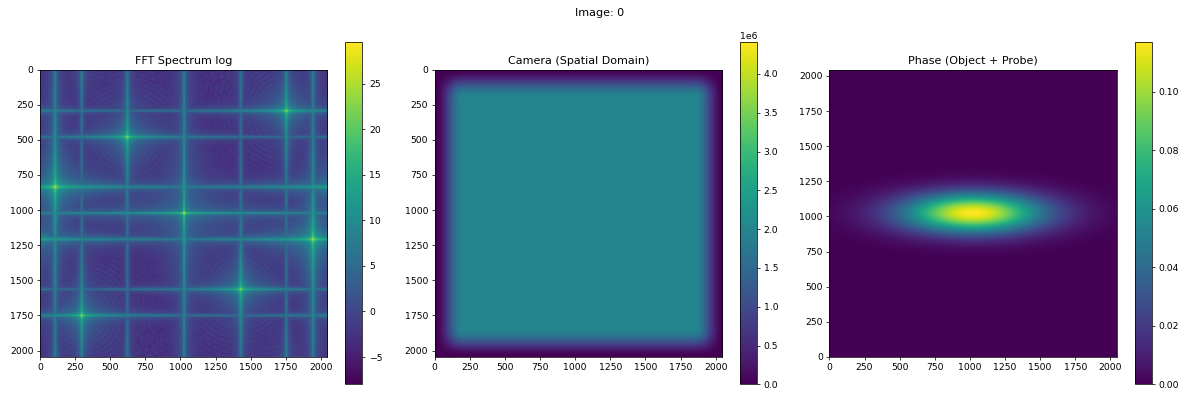

0


<IPython.core.display.Javascript object>


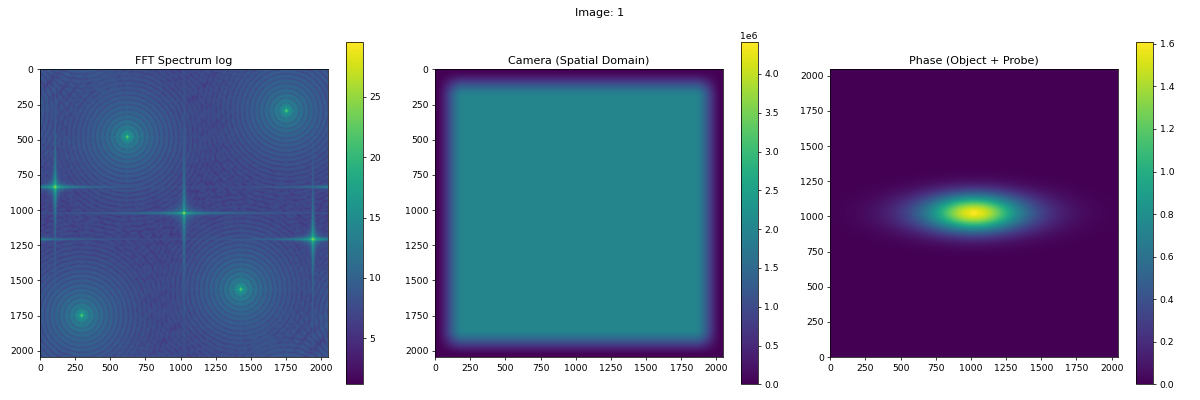

1


<IPython.core.display.Javascript object>


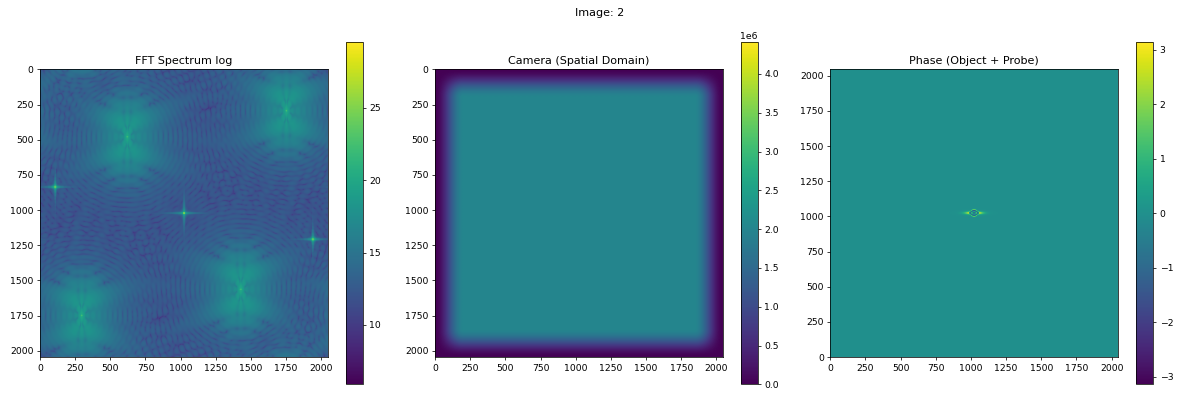

2


In [314]:
import numpy as np
import matplotlib.pyplot as plt
 
# Revised function definition for generating parameter values
def f(start_point, end_point, transition_point, transition_rate, steps):
    x = np.linspace(0, 20, steps)
    return ((start_point - end_point) / (np.exp(transition_rate * (x - transition_point)) + 1)) + end_point
 

#Grid size and wave parameters
lamb0 = 0.02
k = 2 * np.pi / lamb0  # Wave number
 
size_grid_x, size_grid_y = 2046, 2046
x = np.linspace(-20, 20, size_grid_x)
y = np.linspace(-20, 20, size_grid_y)
 

size = (size_grid_x, size_grid_y)
x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))
 

# Reference wave angles
theta1_deg = -45
theta2_deg = 49
theta1 = np.radians(theta1_deg)
theta2 = np.radians(theta2_deg)
 
r1 = r2 = 1000
p1 = 100
 
Psi_probe = p1 * np.exp(-1j * (k * x))
Psi_ref1 = r1 * np.exp(-1j * (k * (x * np.cos(theta1) + y * np.sin(theta1))))
Psi_ref2 = r2 * np.exp(-1j * (k * (x * np.cos(theta2) + y * np.sin(theta2))))
 
# Number of steps
steps = 3
 
# Generate parameter values for the first TF
n0_tf1_values = f(0.0, 6, 15, 1, steps)  # Amplitude of the first TF
rx1_values = f(30, 30, 15, 1, steps)    # Radius in x for the first TF
ry1_values = f(30, 30, 15, 1, steps)    # Radius in y for the first TF
 
# Generate parameter values for the Gaussian
amp_gauss_values = f(0.01, 5.4, 13, 0.3, steps)
sigma_x_values = f(400, 40, 15, 0.8, steps)
sigma_y_values = f(100, 5, 15, 0.8, steps)
p_values = f(0.99, 0.4, 15, 1, steps)
alpha_values = f(0.000001, 0.0001, 13, 1, steps)
 
# Offset for Gaussian center (x0_gs, y0_gs) to simulate movement
x0_gs_values = np.linspace(size_grid_x // 2, size_grid_x // 2, steps)  # Moving x-coordinate of the Gaussian center
y0_gs_values = np.linspace(size_grid_y // 2, size_grid_y // 2, steps)  # Moving y-coordinate of the Gaussian center
 
x0_tf,y0_tf = size_grid_x//2,size_grid_y//2
 
# Combine parameters into a list for visualization
parameters = [
    ("n0_tf1_values", n0_tf1_values),
    ("rx1_values", rx1_values),
    ("ry1_values", ry1_values),
    ("amp_gauss_values", amp_gauss_values),
    ("sigma_x_values", sigma_x_values),
    ("sigma_y_values", sigma_y_values),
    ("p_values", p_values),
    ("alpha_values", alpha_values),
    ("x0_gs_values", x0_gs_values),  # Add Gaussian center movement for visualization
    ("y0_gs_values", y0_gs_values)   # Add Gaussian center movement for visualization
]
 
# Create a grid of plots
fig, axs = plt.subplots(6, 2, figsize=(12, 18))  # 6 rows, 2 columns (adjust for all parameters)
 
x_values = np.linspace(0, steps, steps)  # X-axis values ranging from 0 to 40
 
# Plot each parameter
for i, (name, values) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(x_values, values, label=name, color='b')  # Use x_values for x-axis
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel("Steps (0 to 20)")
    axs[row, col].set_ylabel("Value")
    axs[row, col].legend()
    axs[row, col].set_xlim(0, steps)  # Explicitly set x-axis limit to 40

# Remove unused subplots (if any)
for j in range(len(parameters), 6 * 2):
    fig.delaxes(axs.flatten()[j])

# Adjust layout
plt.tight_layout()
plt.show()


def bi_modal_2d_with_tail(x, y, n0_tf, amp_gauss, sigma_x, sigma_y,x0_tf, y0_tf,x0_gs,y0_gs, rx, ry, alpha=0.1):
    # Gaussian component with tail
    gauss = amp_gauss * np.exp(-((x - x0_gs)**2 / (2 * sigma_x**2) + (y - y0_gs)**2 / (2 * sigma_y**2)))
    tail = 1 / (1 + alpha * ((x - x0_gs)**2 + (y - y0_gs)**2))
 
    gaussian_with_tail = gauss * tail
    # Thomas-Fermi component
    tf = n0_tf * np.maximum(0, 1 - ((x - x0_tf)**2 / rx**2 + (y - y0_tf)**2 / ry**2))
    # Combine both components
    return gaussian_with_tail + tf
 

# Lists to store fft_shifted and fft_magnitude for different sigma values
fft_shifts = []
fft_magnitudes_test = []
 
i = 0
# Loop over decreasing sigma_x and sigma_y values, and other parameters
for sigma_x, sigma_y, rx1, ry1, n0_tf1, amp_gauss, alpha,x0_gs,y0_gs in zip(sigma_x_values, sigma_y_values, rx1_values,
                                                                                             ry1_values, n0_tf1_values,
                                                                                             amp_gauss_values, alpha_values,x0_gs_values,y0_gs_values):
    # Create the bi-modal 2D image with both Thomas-Fermi components
    noise_std_dev = 0.1  # Standard deviation for Gaussian noise
 
    
    # Generate 2D Perlin noise
    # perlin_noise = perlin_noise_2d(bi_modal_image.shape, scale=40, seed=None) * 0.3
 
    
    # Add Gaussian noise
    # noise = np.random.normal(0, noise_std_dev, bi_modal_image.shape)
    # bi_modal_image_noisy = bi_modal_image + perlin_noise
 
    # Create the bi-modal image with both Thomas-Fermi components
    bi_modal_image = bi_modal_2d_with_tail(x, y, n0_tf1, amp_gauss, sigma_x, sigma_y, 
                                           x0_tf, y0_tf, x0_gs, y0_gs, rx1, ry1, 
                                           alpha)  # Radius for the second TF\
    bi_modal_image_noisy = bi_modal_image
    
    # Add phase delay within the ellipsoid
    n = 1.1  # Refractive index
    t = 1  # Thickness of the ellipsoid
    OPD = (2 * np.pi * n * t)
 
    phase_delay = np.exp(1j * bi_modal_image_noisy)
 
    # Apply phase delay conditionally
    Psi_shape = Psi_probe * phase_delay
 
    # Calculate total interference pattern
    Psi_total = Psi_ref2 + Psi_shape + Psi_ref1
    Psi_total = Psi_total * Psi_total.conj()  # Intensity pattern

    Psi_total = f1.squaroid(Psi_total, width=0.20)
 
    # FFT of Psi_total
    fft_result = np.fft.fft2(Psi_total)
 
    fft_shifted = np.fft.fftshift(fft_result)
    fft_magnitude = np.abs(fft_shifted)
 
    # Store the results
    fft_shifts.append(fft_shifted)
    fft_magnitudes_test.append(fft_magnitude)
 
    if i % 1 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
 
        im0 = axs[0].imshow(np.log(fft_magnitude), cmap='viridis')
        axs[0].set_title("FFT Spectrum log")
        fig.colorbar(im0, ax=axs[0], orientation='vertical')
 
        im1 = axs[1].imshow(np.abs(Psi_total), cmap='viridis')
        axs[1].set_title("Camera (Spatial Domain)")
        fig.colorbar(im1, ax=axs[1], orientation='vertical')
 
        im2 = axs[2].imshow(np.angle(Psi_shape), cmap='viridis', origin='lower')
        axs[2].set_title("Phase (Object + Probe)")
        fig.colorbar(im2, ax=axs[2], orientation='vertical')
 
        plt.suptitle(f"Image: {i}")
        plt.tight_layout()
        plt.show()
 
    print(i)
    i += 1

<IPython.core.display.Javascript object>


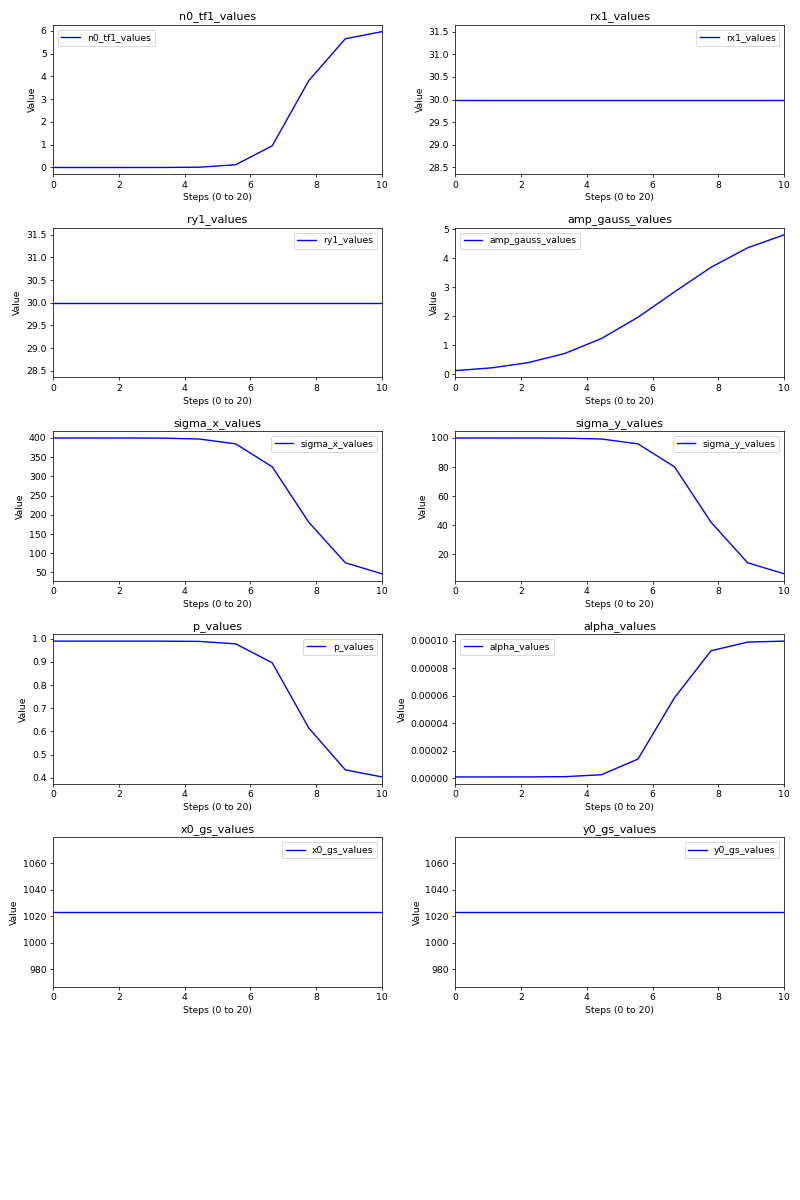

0
1
2
3
4
5
6
7
8
9


In [335]:
raw_atoms = []
raw_flats = []
import numpy as np
import matplotlib.pyplot as plt
 
# Revised function definition for generating parameter values
def f(start_point, end_point, transition_point, transition_rate, steps):
    x = np.linspace(0, 20, steps)
    return ((start_point - end_point) / (np.exp(transition_rate * (x - transition_point)) + 1)) + end_point
 

#Grid size and wave parameters
lamb0 = 0.02
k = 2 * np.pi / lamb0  # Wave number
 
size_grid_x, size_grid_y = 2046, 2046
x = np.linspace(-20, 20, size_grid_x)
y = np.linspace(-20, 20, size_grid_y)
 

size = (size_grid_x, size_grid_y)
x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))
 

# Reference wave angles
theta1_deg = -45
theta2_deg = 49
theta1 = np.radians(theta1_deg)
theta2 = np.radians(theta2_deg)
 
r1 = r2 = 1
p1 = 1
 
Psi_probe = p1 * np.exp(-1j * (k * x))
Psi_ref1 = r1 * np.exp(-1j * (k * (x * np.cos(theta1) + y * np.sin(theta1))))
Psi_ref2 = r2 * np.exp(-1j * (k * (x * np.cos(theta2) + y * np.sin(theta2))))
 
# Number of steps
steps = 10
 
# Generate parameter values for the first TF
n0_tf1_values = f(0.0, 6, 15, 1, steps)  # Amplitude of the first TF
rx1_values = f(30, 30, 15, 1, steps)    # Radius in x for the first TF
ry1_values = f(30, 30, 15, 1, steps)    # Radius in y for the first TF
 
# Generate parameter values for the Gaussian
amp_gauss_values = f(0.01, 5.4, 13, 0.3, steps)
sigma_x_values = f(400, 40, 15, 0.8, steps)
sigma_y_values = f(100, 5, 15, 0.8, steps)
p_values = f(0.99, 0.4, 15, 1, steps)
alpha_values = f(0.000001, 0.0001, 13, 1, steps)
 
# Offset for Gaussian center (x0_gs, y0_gs) to simulate movement
x0_gs_values = np.linspace(size_grid_x // 2, size_grid_x // 2, steps)  # Moving x-coordinate of the Gaussian center
y0_gs_values = np.linspace(size_grid_y // 2, size_grid_y // 2, steps)  # Moving y-coordinate of the Gaussian center
 
x0_tf,y0_tf = size_grid_x//2,size_grid_y//2
 
# Combine parameters into a list for visualization
parameters = [
    ("n0_tf1_values", n0_tf1_values),
    ("rx1_values", rx1_values),
    ("ry1_values", ry1_values),
    ("amp_gauss_values", amp_gauss_values),
    ("sigma_x_values", sigma_x_values),
    ("sigma_y_values", sigma_y_values),
    ("p_values", p_values),
    ("alpha_values", alpha_values),
    ("x0_gs_values", x0_gs_values),  # Add Gaussian center movement for visualization
    ("y0_gs_values", y0_gs_values)   # Add Gaussian center movement for visualization
]
 
# Create a grid of plots
fig, axs = plt.subplots(6, 2, figsize=(12, 18))  # 6 rows, 2 columns (adjust for all parameters)
 
x_values = np.linspace(0, steps, steps)  # X-axis values ranging from 0 to 40
 
# Plot each parameter
for i, (name, values) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(x_values, values, label=name, color='b')  # Use x_values for x-axis
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel("Steps (0 to 20)")
    axs[row, col].set_ylabel("Value")
    axs[row, col].legend()
    axs[row, col].set_xlim(0, steps)  # Explicitly set x-axis limit to 40

# Remove unused subplots (if any)
for j in range(len(parameters), 6 * 2):
    fig.delaxes(axs.flatten()[j])

# Adjust layout
plt.tight_layout()
plt.show()


def bi_modal_2d_with_tail(x, y, n0_tf, amp_gauss, sigma_x, sigma_y,x0_tf, y0_tf,x0_gs,y0_gs, rx, ry, alpha=0.1):
    # Gaussian component with tail
    gauss = amp_gauss * np.exp(-((x - x0_gs)**2 / (2 * sigma_x**2) + (y - y0_gs)**2 / (2 * sigma_y**2)))
    tail = 1 / (1 + alpha * ((x - x0_gs)**2 + (y - y0_gs)**2))
 
    gaussian_with_tail =  gauss
    # Thomas-Fermi component
    tf = n0_tf * np.maximum(0, 1 - ((x - x0_tf)**2 / rx**2 + (y - y0_tf)**2 / ry**2))
    # Combine both components
    return gaussian_with_tail + tf
 

# Lists to store fft_shifted and fft_magnitude for different sigma values
fft_shifts = []
fft_magnitudes_test = []
 
i = 0
# Loop over decreasing sigma_x and sigma_y values, and other parameters
for sigma_x, sigma_y, rx1, ry1, n0_tf1, amp_gauss, alpha,x0_gs,y0_gs in zip(sigma_x_values, sigma_y_values, rx1_values,
                                                                                             ry1_values, n0_tf1_values,
                                                                                             amp_gauss_values, alpha_values,x0_gs_values,y0_gs_values):
    # Create the bi-modal 2D image with both Thomas-Fermi components
    noise_std_dev = 0.1  # Standard deviation for Gaussian noise
 
    
    # Generate 2D Perlin noise
    # perlin_noise = perlin_noise_2d(bi_modal_image.shape, scale=40, seed=None) * 0.3
 
    
    # Add Gaussian noise
    # noise = np.random.normal(0, noise_std_dev, bi_modal_image.shape)
    # bi_modal_image_noisy = bi_modal_image + perlin_noise
 
    # Create the bi-modal image with both Thomas-Fermi components
    bi_modal_image = bi_modal_2d_with_tail(x, y, n0_tf1, amp_gauss, sigma_x, sigma_y, 
                                           x0_tf, y0_tf, x0_gs, y0_gs, rx1, ry1, 
                                           alpha)  # Radius for the second TF\
    bi_modal_image_noisy = bi_modal_image

    phase_delay = np.exp(3j * bi_modal_image_noisy)
 
    # Apply phase delay conditionally
    Psi_shape = Psi_probe * phase_delay
 
    # Calculate total interference pattern
    Psi_total = Psi_ref2 + Psi_shape + Psi_ref1
    Psi_background = Psi_ref2 + Psi_shape + Psi_ref1
    
    Psi_total = Psi_total * Psi_total.conj()  # Intensity pattern
    Psi_background = Psi_background * Psi_background.conj()  # Intensity pattern

#     Psi_total = f1.squaroid(Psi_total, width=0.20)
 
    # FFT of Psi_total
    fft_result = np.fft.fft2(Psi_total)
 
    fft_shifted = np.fft.fftshift(fft_result)
    fft_magnitude = np.abs(fft_shifted)
 
    # Store the results
    fft_shifts.append(fft_shifted)
    fft_magnitudes_test.append(fft_magnitude)    
    raw_atoms.append(abs(Psi_total))
    raw_flats.append(abs(Psi_background))
    print(i)
    i += 1

Using the new box cutter
------ r='quad1' ------
Using quad1
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad1' ------
Using quad1
Indices provided: 
(2046, 2046) (2046, 2046)
Using the new box cutter
------ r='quad2' ------
Using quad2
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad2' ------
Using quad2
Indices provided: 
(2046, 2046) (2046, 2046)


<IPython.core.display.Javascript object>


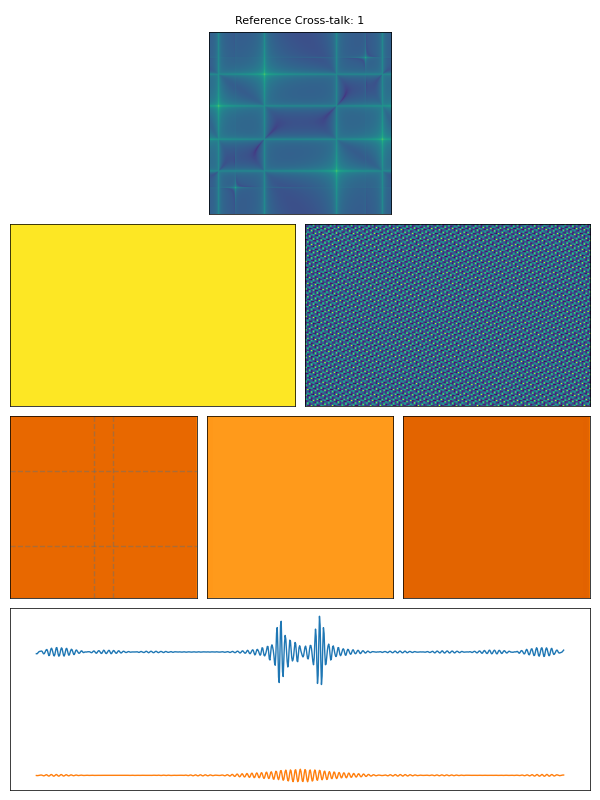

<ipython-input-338-b064105f932a>:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Using the new box cutter
------ r='quad1' ------
Using quad1
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad1' ------
Using quad1
Indices provided: 
(2046, 2046) (2046, 2046)
Using the new box cutter
------ r='quad2' ------
Using quad2
Using the new box cutter
Indices provided: 
Indices provided: 
------ r='quad2' ------
Using quad2
Indices provided: 
(2046, 2046) (2046, 2046)


<IPython.core.display.Javascript object>


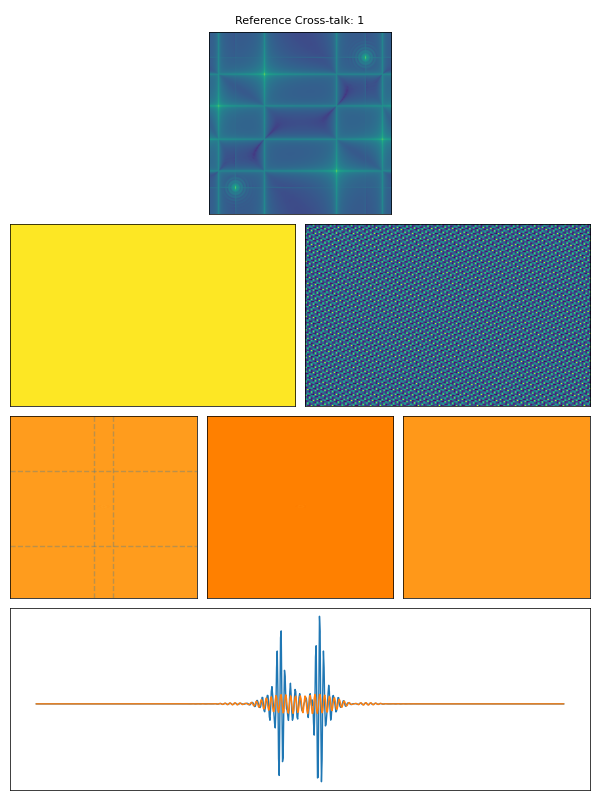

In [338]:
for FS, atoms, flat in zip(fft_shifts[::5], raw_atoms[::5], raw_flats[::5]):
    # add noise 
#     atoms = atoms * np.random.normal(np.mean(atoms), noise_amount, atoms.shape)
#     flat = flat * np.random.normal(np.mean(flat), noise_amount, flat.shape)

    # Minus for ref cross-talk
    ang1 = (1-2*rc_b)*HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1")
    ang2 = (1-2*rc_b)*HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2")

    fig = plt.figure(layout="constrained", figsize=(9, 12))
    gs = GridSpec(4, 6, figure=fig)
    ax0 = fig.add_subplot(gs[0, :])
    axatoms = fig.add_subplot(gs[1, 0:3])
    axflat = fig.add_subplot(gs[1, 3:])
    ax1 = fig.add_subplot(gs[2, 0:2])
    ax2 = fig.add_subplot(gs[2, 2:4])
    axdiff = fig.add_subplot(gs[2, 4:6])
    ax3 = fig.add_subplot(gs[3, :])

    ax0.imshow(np.log(np.abs((FS))),cmap='viridis')# aspect='auto', vmin=-10, vmax=10)#, vmin=0, vmax=1000)
    axatoms.imshow(atoms, aspect='auto', vmin=-1.3, vmax=1.3 )
    axflat.imshow(flat[550:700, 550:700], aspect='auto')# vmin=-1.3, vmax=1.3 )

    ax1.imshow(ang1, cmap="afmhot_r", origin="lower", aspect='auto')
    ax2.imshow(ang2, cmap="afmhot_r", origin="lower", aspect='auto')
    axdiff.imshow(ang1-ang2, cmap="afmhot_r", origin="lower", aspect='auto')

    wdth_y = 100
    wdth_x = 400

    ax1.axvline(x=1023-border_x-wdth_y, alpha=0.3, ls='--')
    ax1.axvline(x=1023-border_x+wdth_y, alpha=0.3, ls='--')
    ax1.axhline(y=1003-border_z-wdth_x, alpha=0.3, ls='--')
    ax1.axhline(y=1003-border_z+wdth_x, alpha=0.3, ls='--')

    ax3.plot(ang1.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C0')
    ax3.plot(ang2.T[1023-border_z-wdth_y:1023-border_z+wdth_y, 1023-border_x-wdth_x:1023-border_x+wdth_x].mean(axis=0), c='C1')


    for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f"Reference Cross-talk: {rc_b}")
    plt.tight_layout()

#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/OAH_missmatch/simulations/w_z_ref_cross/{str(round(w_y*1000)).zfill(6)}.png")
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import random
 
# Generate a random seed
 
# Parameters for the cuts (example values)
radius = 100
cut_x = 1000  # x-coordinate for vertical cut
cut_y = 1000  # y-coordinate for horizontal cut
cut_range = slice(150, 1800)  # Range of the cut
major_axial, minor_axial = 300, 300  # Semi-major and semi-minor axes
 
# List to store the cuts for each image
cuts_list = []
 

# Process FFT magnitudes
for i, fft_magnitude in enumerate(fft_magnitudes_test):
    threshold_abs = 0.01 * fft_magnitude.max()
    coordinates = peak_local_max(fft_magnitude, min_distance=5, threshold_abs=threshold_abs)
    coordinates_sorted = sorted(coordinates, key=lambda coord: (coord[0], coord[1]), reverse=True)
 
    if len(coordinates_sorted) > 1:
        x1, y1 = coordinates_sorted[1]
        x2, y2 = coordinates_sorted[0]

        # x1, y1 = coordinates_sorted[5]
        # x2, y2 = coordinates_sorted[0]
 
        y_grid, x_grid = np.meshgrid(np.arange(fft_magnitude.shape[1]), np.arange(fft_magnitude.shape[0]))
        mask1 = (((x_grid - x1)**2) / (major_axial**2)) + (((y_grid - y1)**2) / (minor_axial**2)) <= 1
        mask2 = (((x_grid - x2)**2) / (major_axial**2)) + (((y_grid - y2)**2) / (minor_axial**2)) <= 1
 
        masked_fft1 = fft_shifts[i] * mask1
        masked_fft2 = fft_shifts[i] * mask2
        perlin_noise1 = generate_perlin_noise_2d_tf(bi_modal_image_noisy.shape, scale=110, seed=123) * 0.3
        perlin_noise2 = generate_perlin_noise_2d_tf(bi_modal_image_noisy.shape, scale=110, seed=456) * 0.3       
        inverse_fft1 = np.fft.ifft2(np.fft.ifftshift(masked_fft1)) / (Psi_ref2.conj() * Psi_probe)
        inverse_fft2 = np.fft.ifft2(np.fft.ifftshift(masked_fft2)) / (Psi_ref1.conj() * Psi_probe)
        ang1 = unwrap_phase(np.angle(inverse_fft1)) + perlin_noise1.numpy() 
        ang2 = unwrap_phase(np.angle(inverse_fft2)) + perlin_noise2.numpy()
 
        # Generate Perlin noise
        size = 1650
        scale = 40
        # Define cuts and apply Perlin noise
        horizontal_ang1 = ang1[cut_x, cut_range]
        horizontal_ang2 = ang2[cut_x, cut_range]
 
        vertical_ang2 = ang2[cut_range, cut_y]
        vertical_ang1 = ang1[cut_range, cut_y]   
 
 
        cuts_list.append({
            'fft_index': i,
            'horizontal_ang1': horizontal_ang1,
            'vertical_ang1': vertical_ang1,
            'horizontal_ang2': horizontal_ang2,
            'vertical_ang2': vertical_ang2
        })
 
        if i % 1 == 0:
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes[0][0].scatter(np.arange(0, len(horizontal_ang1)), horizontal_ang1, s=5)
            axes[0][0].set_title(f"Horizontal Ang1 for FFT {i + 1}")
            axes[0][1].scatter(np.arange(0, len(horizontal_ang2)), horizontal_ang2, s=5)
            axes[0][1].set_title(f"Horizontal Ang2 for FFT {i + 1}")
            axes[1][0].scatter(np.arange(0, len(vertical_ang1)), vertical_ang1, s=5)
            axes[1][0].set_title(f"Vertical Ang1 for FFT {i + 1}")
            axes[1][1].scatter(np.arange(0, len(vertical_ang2)), vertical_ang2, s=5)
            axes[1][1].set_title(f"Vertical Ang2 for FFT {i + 1}")
            axes[0][2].imshow(ang1)
            axes[0][2].set_title("Reconstructed object ang1")
            axes[1][2].imshow(ang2)
            axes[1][2].set_title("Reconstructed object ang2")
            axes[0][3].imshow(np.log(np.abs(fft_magnitude) + 1), cmap='viridis', extent=[0, fft_magnitude.shape[1], 0, fft_magnitude.shape[0]])
            axes[0][3].imshow(mask1, alpha=0.5, cmap='coolwarm', extent=[0, fft_magnitude.shape[1], 0, fft_magnitude.shape[0]])
            axes[0][3].set_title("FFT spherical cut ang1")
            axes[1][3].imshow(np.log(np.abs(fft_magnitude) + 1), cmap='viridis', extent=[0, fft_magnitude.shape[1], 0, fft_magnitude.shape[0]])
            axes[1][3].imshow(mask2, alpha=0.5, cmap='coolwarm', extent=[0, fft_magnitude.shape[1], 0, fft_magnitude.shape[0]])
            axes[1][3].set_title("FFT spherical cut ang2")
            plt.suptitle(f"Image: {i}")
            plt.tight_layout()
            plt.show()
    else:
        print(f"Not enough peaks detected for FFT {i + 1}, skipping inverse FFT and cuts.")

In [342]:
import tensorflow as tf
def generate_perlin_noise_2d_tf(shape, scale=40, seed=None):
    """
    Generate 2D Perlin noise using NumPy for random gradients and TensorFlow for processing.
 
    Parameters:
        shape (tuple): Dimensions of the output tensor (height, width).
        scale (int): Controls the frequency of the noise. Smaller values create smoother noise.
        seed (int): Random seed for reproducibility.
 
    Returns:
        tf.Tensor: 2D tensor of Perlin noise.
    """
    if seed is not None:
        np.random.seed(seed)
 
    height, width = shape
    grad_shape = (height // scale + 2, width // scale + 2)
 
    # Generate random gradients using NumPy
    grad_x = np.random.uniform(-1.0, 1.0, grad_shape).astype(np.float32)
    grad_y = np.random.uniform(-1.0, 1.0, grad_shape).astype(np.float32)
 
    # Convert gradients to TensorFlow tensors
    grad_x = tf.convert_to_tensor(grad_x)
    grad_y = tf.convert_to_tensor(grad_y)
 
    def fade(t):
        """Fade function to smooth the transitions."""
        return t * t * t * (t * (t * 6 - 15) + 10)
 
    # Create a grid of coordinates
    x_coords = tf.range(width, dtype=tf.float32)
    y_coords = tf.range(height, dtype=tf.float32)
    x_grid, y_grid = tf.meshgrid(x_coords, y_coords)
 
    # Compute grid cell indices
    gx0 = tf.cast(x_grid // scale, tf.int32)
    gy0 = tf.cast(y_grid // scale, tf.int32)
    gx1 = gx0 + 1
    gy1 = gy0 + 1
 
    # Compute local coordinates within each grid cell
    dx = (x_grid % scale) / scale
    dy = (y_grid % scale) / scale
 
    # Combine indices for gathering
    def gather_gradients(gx, gy):
        indices = tf.stack([gy, gx], axis=-1)
        grad_x_val = tf.gather_nd(grad_x, indices)
        grad_y_val = tf.gather_nd(grad_y, indices)
        return grad_x_val, grad_y_val
 
    # Gather gradients
    g00x, g00y = gather_gradients(gx0, gy0)
    g01x, g01y = gather_gradients(gx0, gy1)
    g10x, g10y = gather_gradients(gx1, gy0)
    g11x, g11y = gather_gradients(gx1, gy1)
 
    # Dot product with distance vectors
    n00 = g00x * dx + g00y * dy
    n01 = g01x * dx + g01y * (dy - 1)
    n10 = g10x * (dx - 1) + g10y * dy
    n11 = g11x * (dx - 1) + g11y * (dy - 1)
 
    # Apply the fade function
    wx = fade(dx)
    wy = fade(dy)
 
    # Interpolate gradients
    nx0 = (1 - wx) * n00 + wx * n10
    nx1 = (1 - wx) * n01 + wx * n11
    noise = (1 - wy) * nx0 + wy * nx1
 
    # Normalize the noise to [-1, 1]
    noise -= tf.reduce_mean(noise)
    noise /= tf.reduce_max(tf.abs(noise))
 
    return noise

<IPython.core.display.Javascript object>


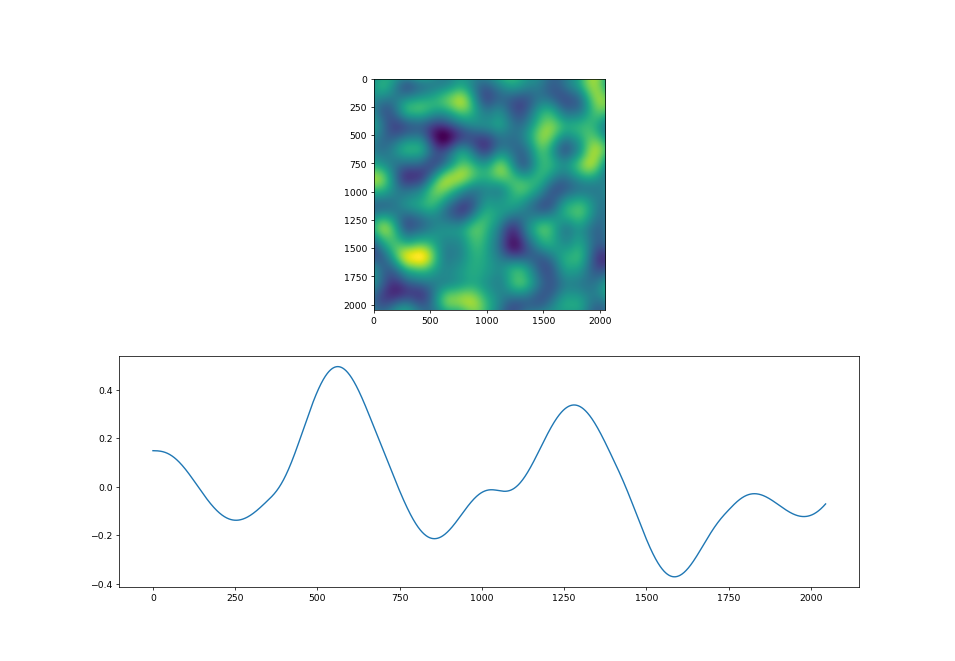

In [366]:
fig, ax = plt.subplots(2, 1)
noise = generate_perlin_noise_2d_tf((2046, 2046), scale=350, seed=None)

ax[0].imshow(noise)
ax[1].plot(noise[1023])
plt.show()
